<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/05-many-two-state-systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-many-two-state-systems.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 5 - Many two state systems

> TODO: Intro

In [219]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import Image, Math
import gif
import numpy as np
import pandas as pd
from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals
import warnings
warnings.filterwarnings('ignore')
from itertools import product
import os
from fractions import Fraction

# Functions created in 04 tutorial

from libs.helper_05_tutorial import *

def prettify_states(states, mm_list):
    pretty_states = np.zeros([len(mm_list),len(states)], dtype="object")
    
    for j, state in enumerate(states):
        x = []
        for i, val in enumerate(state):
            pretty_states[i,j] = f"{val[0,0]:.1f}"
        
    return pd.DataFrame(data=pretty_states, index=mm_list)

As soon as we start adding more than one TSS things get quite complicated. In order to give us an intuition for how such systems behave, we will take inspiration from Tutorials 1 and 2.

Recall that when we started in [Tutortial 2](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/02-perturbing-a-two-state-system.ipynb#2.1-Static-perturbation) we motivated that a single TSS whose states have the same energy $E_0$, are coupled together with strength $A$ and are subject to some kind of external perturbation $\delta$ can be described by a Hamiltonian

$$
H = \begin{bmatrix}
 E_0 + \delta  &  -A  \\
 -A  &  E_0 - \delta  \\
\end{bmatrix} = E_0 I - A \sigma_x + \delta\sigma_z
$$


We now recognise that we can always shift all energies in the Hamiltonian by a constant amount so, without loss of generality, we can set $E_0=0$ leaving us with the following Hamiltonian

$$
H = - A \sigma_x + \delta\sigma_z
$$


A natural starting point for the Hamiltonian of $N$ of these TSS is then

$$
H = - A \overset{N}{\underset{n=1}{\Sigma}} \sigma_{n x} + \delta \overset{N}{\underset{n=1}{\Sigma}} \sigma_{n z}
$$

where the index $n$ refers to a particular TSS.

You may recall that there are mathematical similarities between a TSS and a spin $1/2$ particle. When considering many TSS, we will find it invaluable to refer to well known spin results, such as conservation of angular momentum, to help us solve problems. In light of this, we will introduce a factor of $1/2$ into the Hamiltonian:

$$
H = - A \frac{1}{2}\overset{N}{\underset{n=1}{\Sigma}} \sigma_{n x} + \frac{1}{2}\delta \overset{N}{\underset{n=1}{\Sigma}} \sigma_{n z}
$$

so that we can rewrite our operators as spin operators, (denoted by $S$), for a [spin $1/2$ particle](https://en.wikipedia.org/wiki/Spin-%C2%BD#Observables), i.e.

$$
H = - A \overset{N}{\underset{n=1}{\Sigma}} S_{n x} + \delta \overset{N}{\underset{n=1}{\Sigma}} S_{n z}
$$

Because spin represents angular momentum, the combination of spin operators above is mathematically the same as how one would create the [total angular momentum operators](https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf) - denoted by $J$, e.g. $Jx = \overset{N}{\underset{n=1}{\Sigma}} S_{n x}$. The Hamiltonian can then be written more compactly as:

$$
H = - A J_{x} + \delta J_{z}
$$

Let's see what we can learn from this.

## 5.2 - 2 two-state systems

Let's start simple and look at 2 TSS, i.e. $N=2$. In this coupled system we have 4 states:
- |+,+>
- |+,->
- |-,+>
- |-,->

In [Tutorial 3](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/03-a-two-state-system-in-a-quantised-field.ipynb#3.5---Describing-coupled-systems-in-QuTiP) we learnt how to describe such coupled states in QuTiP by using the tensor product.

Specifically, we would create the |+,-> state by doing:

In [10]:
tensor(basis(2,0), basis(2,1))

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]

We can keep track of which state corresponds to which row by using the `product` function that we introduced in the previous tutorial. Specifically:

In [11]:
possible_ms = ["+","-"]
mm_list = [m for m in product(possible_ms, possible_ms)]
mm_list

[('+', '+'), ('+', '-'), ('-', '+'), ('-', '-')]

And so, the row number 1 of the state vector corresponds to the state:

In [12]:
mm_list[1]

('+', '-')

The tensor product could also be used for operators. For 2 TSS without a quantised field, we can create the tensorised $S_{x1}$ and $S_{x2}$ operators by doing:

In [13]:
Sx1 = tensor(sigmax()/2, qeye(2))
Sx2 = tensor(qeye(2), sigmax()/2)

In [14]:
Sx1

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.  0.5 0. ]
 [0.  0.  0.  0.5]
 [0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]]

In [15]:
Sx2

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.5 0.  0. ]
 [0.5 0.  0.  0. ]
 [0.  0.  0.  0.5]
 [0.  0.  0.5 0. ]]

This way of creating operators is fine for a few TSS, but the process of making these tensor products can get a bit laborious. Luckily, QuTiP has a function that can generate all of the $S$ operators for $N$ TSS with a single line of code - [`spin_algebra(N)`](http://qutip.org/docs/latest/apidoc/functions.html#qutip.piqs.spin_algebra).

Let's try it it out.

In [16]:
S = spin_algebra(2)

In [17]:
len(S)

3

Now looking at the 0th entry in the `spin_algebra` list we find that it's equal to $[S_{1x}, S_{2x}]$ (we would find a equivalent for $S_{y}$ and $S_{z}$)

In [18]:
S[0]

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0.  0.  0.5 0. ]
  [0.  0.  0.  0.5]
  [0.5 0.  0.  0. ]
  [0.  0.5 0.  0. ]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0.  0.5 0.  0. ]
  [0.5 0.  0.  0. ]
  [0.  0.  0.  0.5]
  [0.  0.  0.5 0. ]]]

This is very convenient! We can then write our $J$ operators as:

In [19]:
Jx = S[0][0] + S[0][1]
Jy = S[1][0] + S[1][1]
Jz = S[2][0] + S[2][1]


We proceed as we have done several times by looking for the stationary states of the system. When the system is in one of these states it will remain there for all time. Such states are described by a single constant energy.

To find the states of constant energy, we'll follow what we did in Tutorial 1 and calculate the eigenvalues and eigenvectors of the Hamiltonian.

In [198]:
A=0.1

In [199]:
H = - A*Jx

In [200]:
evals, ekets = H.eigenstates()

In [201]:
evals

array([-1.00000000e-01,  0.00000000e+00,  9.71445147e-17,  1.00000000e-01])

In [204]:
prettify_states(ekets, mm_list)

,0,1,2,3
"(+, +)",0.5+0.0j,0.0+0.0j,0.7+0.0j,0.5+0.0j
"(+, -)",0.5+0.0j,0.7+0.0j,0.0+0.0j,-0.5+0.0j
"(-, +)",0.5+0.0j,-0.7+0.0j,0.0+0.0j,-0.5+0.0j
"(-, -)",0.5+0.0j,0.0+0.0j,-0.7+0.0j,0.5+0.0j


Similar to Tutorial 1, because we have coupled the states together the stationary states are now mixtures of the + and - states.

The lowest energy eigenstate (column 0) is an "in phase" mixture of all the different states and the highest energy eigenstate (column 3) is an "out of phase" mixture. 

We also have 2 zero energy engenstates that are either mixtures of |+,+> and |-,-> or |+,-> and |-,+>.

>TODO what is the classial analogy here

In [320]:
# J = jspin(3, basis="uncoupled")

In [329]:
A = 0.1

H = A*Jx

times = np.linspace(0.0, 100.0, 1000) 

psi0=basis(4,0)
#psi0 = estates[3]

result = sesolve(H, psi0, times)

# result = sesolve(H0, basis(7,0), times)

In [330]:
num_states = result.states[0].shape[0]
psi = np.zeros([num_states,times.size], dtype="complex128")
P = np.zeros([num_states,times.size], dtype="complex128")

for i, state in enumerate(result.states):
    psi[:,i] = np.transpose(state)
    P[:,i] = np.abs(psi[:,i]*np.conj(psi[:,i]))

In [331]:
bra_labels, ket_labels = make_braket_labels(mm_list)

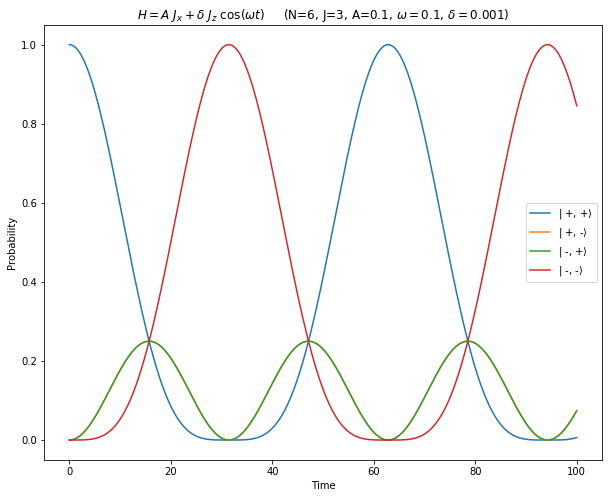

In [333]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("$H =A \ J_x + \delta \ J_z \  \cos (\omega t)$     (N=6, J=3, A=0.1, $\omega = 0.1$, $\delta=0.001$)")
plt.show();


We'll then calculate the eigenvalues of the Hamiltonian (i.e the energies) and see how they depend on the perturbation strength $\delta$. When we did this in Tutorial 2 we discovered an avoided crossing (aka anti-crossing) when the perturbation was zero - this was due to the coupling between the states splitting the energy levels apart.

Let's see what we find.

In [451]:
df = make_df_for_energy_scan("$\delta$/A", -4,4, 100, Jx.shape[0]) 

In [452]:
for i, row in df.iterrows():
    H = - A*Jx + row[ "$\delta$/A"]*A*Jz
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

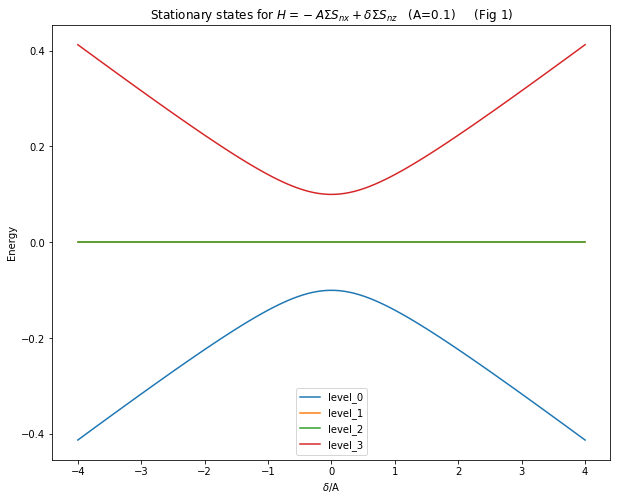

In [453]:
df.plot(x="$\delta$/A",figsize=(10,8),legend=True, 
        title="Stationary states for $H=-A\Sigma S_{nx} + \delta \Sigma S_{nz}$   (A=0.1)     (Fig 1)");
plt.ylabel("Energy");

> TODO: Comment on two degenerate levels and see what the eigenfunctions look like as a function of delta. Use this to motivate different universes that dont talk to each other

In [456]:
ekets

array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.01492875]
 [-0.12126781]
 [-0.12126781]
 [-0.98507125]],
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.17149859]
 [-0.68599434]
 [-0.68599434]
 [ 0.17149859]],
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.70710678]
 [-0.70710678]
 [ 0.        ]],
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.98507125]
 [-0.12126781]
 [-0.12126781]
 [ 0.01492875]]], dtype=object)

> TODO: link back to conservation of angular momentum and motivate J^2 operator

In [457]:
J2 = Jx**2 + Jy**2 + Jz**2

In [458]:
J2

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 2.]]

> TODO: See that J2 is indeed conserved by commutator with the last Hamiltonian we just calculated

In [459]:
commutator(H,J2)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

> TODO: Transform to basis of constant energy reveals level 3 has a different J^2 - this is why it cannot mix with the -- and ++ states which have J^2 of 2

In [27]:
J2.transform(ekets)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 2.]]

> TODO: Better to work in a basis of constant "angular momentum"

In [479]:
J = jspin(2)

In [480]:
J

[Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0.         0.70710678 0.         0.        ]
  [0.70710678 0.         0.70710678 0.        ]
  [0.         0.70710678 0.         0.        ]
  [0.         0.         0.         0.        ]],
 Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0.+0.j         0.-0.70710678j 0.+0.j         0.+0.j        ]
  [0.+0.70710678j 0.+0.j         0.-0.70710678j 0.+0.j        ]
  [0.+0.j         0.+0.70710678j 0.+0.j         0.+0.j        ]
  [0.+0.j         0.+0.j         0.+0.j         0.+0.j        ]],
 Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[ 1.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0. -1.  0.]
  [ 0.  0.  0.  0.]]]

In [481]:
Jx = J[0]
Jy = J[1]
Jz = J[2]

In [466]:
A = 0.01

In [467]:
H =  A*Jx

In [482]:
J2 = Jx**2 + Jy**2 + Jz**2

In [483]:
J2

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]]

> TOTO: moivate where j comes in and how it's related to j(j+1). QuTiP has functions for this stuff

In [491]:
N=100

j_vals(N)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])

In [493]:
m_vals(41)

array([-41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29,
       -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16,
       -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,
        -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
        11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
        24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
        37,  38,  39,  40,  41])

In [494]:
m_degeneracy(N,4)

47

In [495]:
def j_states_list(num_tss):
    i=0
    
    jm_list = []
    j_index = {}

    js = j_vals(num_tss)[::-1]
    
    for j in js:
        j_index[j] = []
        ms = m_vals(j)[::-1]
        for m in ms:
            j_index[j].append(i)
            jm_list.append((j,m))
            i+=1
    return j_index, jm_list

In [505]:
def make_braket_labels(jm_list):
    bra_labels = ["$\langle$"+str(Fraction(j))+", "+str(Fraction(m))+" |" for (j,m) in jm_list]
    ket_labels = ["| "+str(Fraction(j))+", "+str(Fraction(m))+"$\\rangle$" for (j,m) in jm_list]
    return bra_labels, ket_labels

In [178]:
def make_operators(num_tss, j):
    
    j_index, jm_list = j_states_list(num_tss)
    
    try:
        j_index[j]
    except:
        raise Exception(f"j needs to be one of {j_vals(num_tss)}")
    
    Js = jspin(num_tss)
    Jx = Js[0]
    Jz = Js[2]
    

    
    num_ms = len(m_vals(j))
    Jz = Jz.extract_states(j_index[j])
    Jx = Jx.extract_states(j_index[j])
    jm_list = [jm_list[i] for i in j_index[j]]
    
    
    
    return Jz, Jx, jm_list

In [543]:
Jz, Jx, jm_list = make_operators(6, 3)

In [544]:
df = make_df_for_energy_scan("$\Delta E$/A", -4,4, 100, Jz.shape[0])

In [545]:
A=0.1
for i, row in df.iterrows():
    H =  row[ "$\Delta E$/A"]*A*Jz +  A*Jx
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

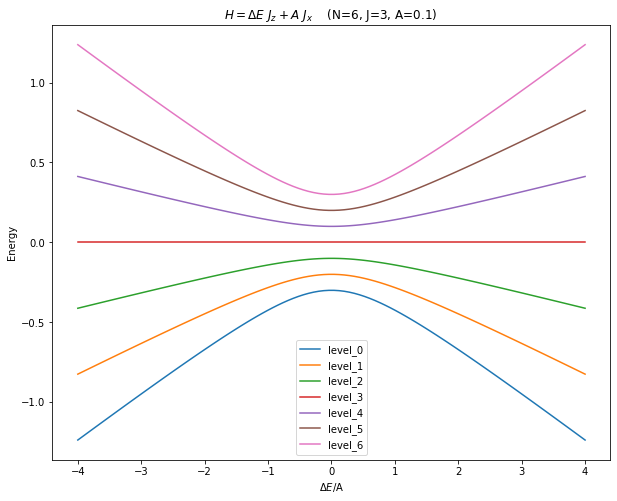

In [546]:
df.plot(x="$\Delta E$/A",figsize=(10,8),legend=True, 
        title="$H=\Delta E \ J_z + A \ J_x$    (N=6, J=3, A=0.1) ");
plt.ylabel("Energy");

In [169]:
bra_labels, ket_labels = make_braket_labels(jm_list)

In [353]:
delta = 0.001
A = 0.1

H0 = A*Jx

evals, estates = H0.eigenstates()

H1 =  delta*Jz

H = [H0,[H1,'cos(w*t)']]

times = np.linspace(0.0, 20000.0, 1000) 

#psi0=basis(4,0)
psi0 = estates[0]

result = sesolve(H, psi0, times, args={'w':A})

# result = sesolve(H0, basis(7,0), times)



In [354]:
num_states = result.states[0].shape[0]
psi = np.zeros([num_states,times.size], dtype="complex128")
P = np.zeros([num_states,times.size], dtype="complex128")

for i, state in enumerate(result.states):
    transformed_state = state.transform(estates)
    psi[:,i] = np.transpose(transformed_state)
    P[:,i] = np.abs(psi[:,i]*np.conj(psi[:,i]))

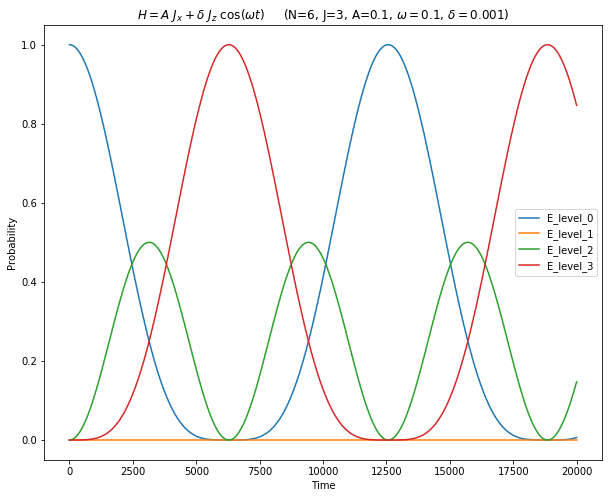

In [355]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"E_level_{i}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("$H =A \ J_x + \delta \ J_z \  \cos (\omega t)$     (N=6, J=3, A=0.1, $\omega = 0.1$, $\delta=0.001$)")
plt.show();

In [548]:
H0 = A*Jx

In [549]:
evals, estates = H0.eigenstates()

In [550]:
evals

array([-3.00000000e-01, -2.00000000e-01, -1.00000000e-01,  2.22044605e-16,
        1.00000000e-01,  2.00000000e-01,  3.00000000e-01])

In [551]:
estates

array([Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[ 0.125     ]
 [-0.30618622]
 [ 0.48412292]
 [-0.55901699]
 [ 0.48412292]
 [-0.30618622]
 [ 0.125     ]],
       Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[-0.30618622]
 [ 0.5       ]
 [-0.39528471]
 [ 0.        ]
 [ 0.39528471]
 [-0.5       ]
 [ 0.30618622]],
       Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[ 0.48412292]
 [-0.39528471]
 [-0.125     ]
 [ 0.4330127 ]
 [-0.125     ]
 [-0.39528471]
 [ 0.48412292]],
       Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[-0.55901699]
 [ 0.        ]
 [ 0.4330127 ]
 [ 0.        ]
 [-0.4330127 ]
 [ 0.        ]
 [ 0.55901699]],
       Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[ 0.48412292]
 [ 0.39528471]
 [-0.125     ]
 [-0.4330127 ]
 [-0.125     ]
 [ 0.39528471]
 [ 0.48412292]],
       Quantum object: dims = [[7], [1]], shape = (7, 1), ty

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18266ea908>)

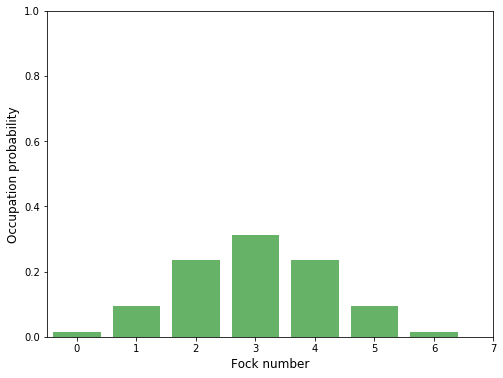

In [554]:
plot_fock_distribution(estates[6])

In [273]:
jm_list

[(3.0, 3.0),
 (3.0, 2.0),
 (3.0, 1.0),
 (3.0, 0.0),
 (3.0, -1.0),
 (3.0, -2.0),
 (3.0, -3.0)]

[Wolfram alpha eigenvalues](https://www.wolframalpha.com/input/?i=%7B%7B1%2Ca%2C0%7D%2C%7Ba%2C0%2Ca%7D%2C%7B0%2Ca%2C-1%7D%7D+eigenvalues)



In [176]:
"#' + '.join(x))
#             x.append(f"{val[0,0]:.2f}" + '|'+','.join(mm_list[j])+'>')"

SyntaxError: EOL while scanning string literal (<ipython-input-176-647971f197cd>, line 1)